In [1]:
pip install yfinance pandas matplotlib numpy scikit-learn tensorflow

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error

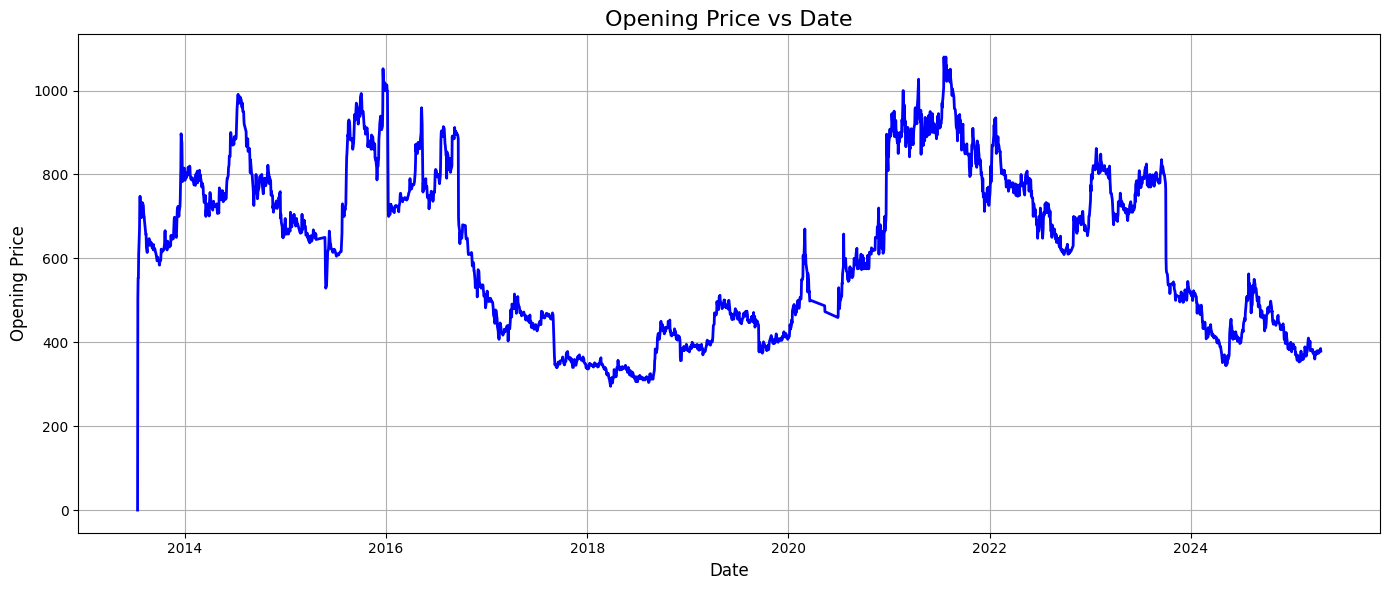

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load your data (replace 'your_file.csv' with the actual file name)
data = pd.read_csv('/content/nic_asia_price_history.csv')

# Reverse the order of rows
df = data.iloc[::-1].reset_index(drop=True)

# Step 2: Remove 'S.N.' column if it exists
if 'S.N.' in df.columns:
    df = df.drop(columns=['S.N.'])

# Step 3: Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 4: Clean numeric columns (remove commas and convert to float)
numeric_cols = ['Open', 'High', 'Low', 'Ltp', '% Change', 'Qty', 'Turnover']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# Step 5: Drop rows with missing dates
df = df.dropna(subset=['Date'])

# Step 6: Filter from 2019-01-01 onwards
#df = df[df['Date'] >= '2019-01-01']

# Step 7: Sort by date just in case
df = df.sort_values(by='Date').reset_index(drop=True)

# Step 8: Plot Opening Price vs Date
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Open'], color='blue', linewidth=2)
plt.title('Opening Price vs Date', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np

# --- Feature Calculations ---

# 1. RSI (Relative Strength Index)
def compute_rsi(series, period=15):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['Ltp'], period=14)

# 2. MACD (Moving Average Convergence Divergence)
exp1 = df['Ltp'].ewm(span=12, adjust=False).mean()
exp2 = df['Ltp'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 3. ATR (Average True Range)
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Ltp'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Ltp'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()

# 4. OBV (On-Balance Volume)
df['OBV'] = (np.sign(df['Ltp'].diff()) * df['Qty']).fillna(0).cumsum()

# 5. Bollinger Bands Width
rolling_mean = df['Ltp'].rolling(window=20).mean()
rolling_std = df['Ltp'].rolling(window=20).std()
df['Bollinger_Width'] = (2 * rolling_std) / rolling_mean

# 6. EMA (Exponential Moving Average)
df['EMA_15'] = df['Ltp'].ewm(span=15, adjust=False).mean()

# 7. Volume Moving Average
df['Volume_MA'] = df['Qty'].rolling(window=15).mean()

# 8. ROC (Rate of Change)
df['ROC'] = df['Ltp'].pct_change(periods=5)

# 9. Candle Body to Wick Ratio
df['Body'] = abs(df['Open'] - df['Ltp'])
df['Wick'] = df['High'] - df['Low']
df['Body_Wick_Ratio'] = df['Body'] / df['Wick'].replace(0, np.nan)

# 10. Lagged Closing Price
df['Ltp_Lag1'] = df['Ltp'].shift(1)

# 11. Rolling Standard Deviation
df['Rolling_STD'] = df['Ltp'].rolling(window=15).std()

# 12. Daily Percentage Change
df['Daily_Perc_Change'] = df['Ltp'].pct_change()

# 13. Day of Week
df['Day_of_Week'] = df['Date'].dt.dayofweek

# Final cleanup for extra columns created during intermediate steps
df_features = df[[
    'Date', 'Open', 'High', 'Low', 'Ltp', 'Qty',
    'RSI', 'MACD', 'MACD_Signal', 'ATR', 'OBV',
    'Bollinger_Width', 'EMA_15', 'Volume_MA', 'ROC',
    'Body_Wick_Ratio', 'Ltp_Lag1', 'Rolling_STD',
    'Daily_Perc_Change', 'Day_of_Week'
]].dropna()

df_features.head()


,Date,Open,High,Low,Ltp,Qty,RSI,MACD,MACD_Signal,ATR,OBV,Bollinger_Width,EMA_15,Volume_MA,ROC,Body_Wick_Ratio,Ltp_Lag1,Rolling_STD,Daily_Perc_Change,Day_of_Week
19,2013-08-08,690.0,690.0,670.0,670.0,21368.0,30.061350,38.747556,47.473966,27.142857,-60071.0,0.203738,683.645840,17391.800000,-0.077135,1.000000,690.0,21.249762,-0.028986,3
20,2013-08-11,670.0,670.0,660.0,663.0,6558.0,22.929936,33.642993,44.707771,22.642857,-66629.0,0.162410,681.065110,17011.066667,-0.066197,0.700000,670.0,24.007340,-0.010448,6
21,2013-08-12,663.0,664.0,655.0,657.0,5132.0,23.684211,28.781663,41.522550,22.285714,-71761.0,0.135404,678.056971,14003.200000,-0.064103,0.666667,663.0,24.858648,-0.009050,0
22,2013-08-13,657.0,665.0,650.0,658.0,4580.0,29.365079,24.724705,38.162981,20.357143,-67181.0,0.100151,675.549850,12739.133333,-0.060000,0.066667,657.0,25.427207,0.001522,1
23,2013-08-14,658.0,655.0,628.0,628.0,10225.0,25.874126,18.871251,34.304635,21.071429,-77406.0,0.093242,669.606118,11695.533333,-0.089855,1.111111,658.0,30.776769,-0.045593,2


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Correct list of feature columns
feature_cols = [
    'Open', 'High', 'Low', 'Ltp', 'Qty',
    'RSI', 'MACD', 'MACD_Signal', 'ATR', 'OBV',
    'Bollinger_Width', 'EMA_15', 'Volume_MA', 'ROC',
    'Body_Wick_Ratio', 'Ltp_Lag1', 'Rolling_STD',
    'Daily_Perc_Change', 'Day_of_Week'
]

# Initialize scaler
scaler = MinMaxScaler()

# Apply scaling
scaled_features = scaler.fit_transform(df_features[feature_cols])

# Create a DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)

# Add back the date column for tracking
scaled_df['Date'] = df_features['Date'].values


In [6]:
scaled_df

,Open,High,Low,Ltp,Qty,RSI,MACD,MACD_Signal,ATR,OBV,Bollinger_Width,EMA_15,Volume_MA,ROC,Body_Wick_Ratio,Ltp_Lag1,Rolling_STD,Daily_Perc_Change,Day_of_Week,Date
0,0.503185,0.453162,0.505913,0.480000,0.028411,0.306215,0.770230,0.880793,0.484940,0.353387,0.512576,0.520082,0.038455,0.393389,0.384615,0.505806,0.131759,0.675829,0.500000,2013-08-08
1,0.477707,0.429742,0.492773,0.470968,0.008692,0.233572,0.734919,0.858634,0.390060,0.352825,0.403160,0.516472,0.037529,0.411894,0.269231,0.480000,0.150248,0.722419,1.000000,2013-08-11
2,0.468790,0.422717,0.486202,0.463226,0.006793,0.241255,0.701290,0.833118,0.382530,0.352385,0.331661,0.512263,0.030216,0.415437,0.256410,0.470968,0.155956,0.725932,0.000000,2013-08-12
3,0.461146,0.423888,0.479632,0.464516,0.006058,0.299123,0.673226,0.806206,0.341867,0.352778,0.238328,0.508756,0.027143,0.422378,0.025641,0.463226,0.159767,0.752502,0.166667,2013-08-13
4,0.462420,0.412178,0.450723,0.425806,0.013574,0.263563,0.632734,0.775298,0.356928,0.351901,0.220034,0.500441,0.024606,0.371870,0.427350,0.464516,0.195634,0.634091,0.333333,2013-08-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,0.101911,0.088993,0.118265,0.102632,0.051475,0.561812,0.495601,0.487397,0.151883,0.016870,0.046340,0.087763,0.097225,0.548710,0.244231,0.099484,0.020029,0.765025,0.500000,2025-04-10
2664,0.105732,0.090047,0.113009,0.100697,0.052707,0.554355,0.496943,0.488801,0.157756,0.013473,0.044575,0.088012,0.099069,0.514712,0.084702,0.102632,0.020892,0.738691,1.000000,2025-04-13
2665,0.112102,0.093677,0.118791,0.104232,0.037525,0.649909,0.499567,0.490532,0.152636,0.015893,0.037949,0.088709,0.099387,0.532684,0.213563,0.100697,0.022894,0.766989,0.166667,2025-04-15
2666,0.114650,0.096019,0.120894,0.103058,0.035765,0.605079,0.501150,0.492283,0.146913,0.013586,0.037846,0.089160,0.094305,0.548320,0.342788,0.104232,0.020909,0.742639,0.333333,2025-04-16


In [7]:
scaled_df.shape

(2668, 20)

In [8]:
SEQ_LEN = 10

def create_sequences(data, target_column='Open'):
    X_seq, indicators_seq, y_seq = [], [], []
    for i in range(len(data) - SEQ_LEN):
        past = data.iloc[i:i+SEQ_LEN]
        future = data.iloc[i+SEQ_LEN]

        x_main = past[['Open', 'High', 'Low', 'Ltp', 'Qty']].values  # Sequential features
        x_indicators = past[['RSI', 'MACD', 'MACD_Signal', 'ATR', 'OBV',
    'Bollinger_Width', 'EMA_15', 'Volume_MA', 'ROC',
    'Body_Wick_Ratio', 'Ltp_Lag1', 'Rolling_STD',
    'Daily_Perc_Change', 'Day_of_Week']].iloc[-1].values  # Last day indicators

        X_seq.append(x_main)
        indicators_seq.append(x_indicators)
        y_seq.append(future[target_column])  # target is next day Open price

    return np.array(X_seq), np.array(indicators_seq), np.array(y_seq)

X_seq, X_indicators, y = create_sequences(scaled_df, "Open")

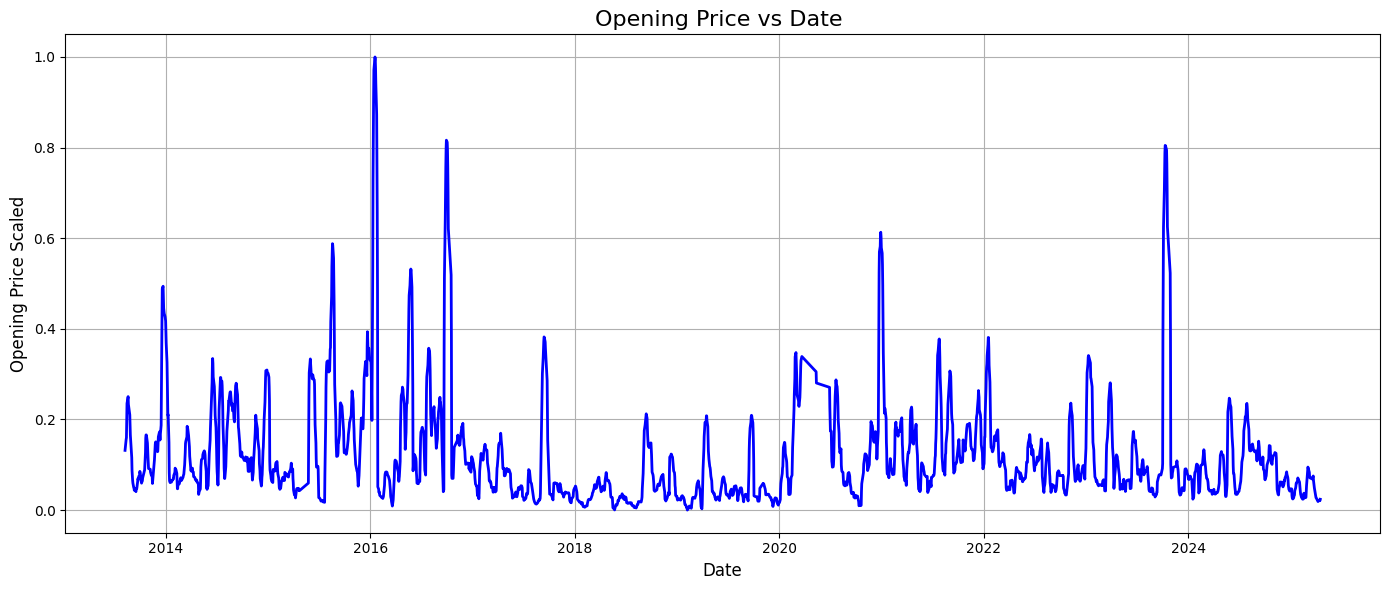

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(scaled_df['Date'], scaled_df['Rolling_STD'], color='blue', linewidth=2)
plt.title('Opening Price vs Date ', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price Scaled', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# LSTM model with technical indicators
def lstm_model(seq_len, seq_features, num_indicators, units=64):
    # Sequential data input
    seq_input = Input(shape=(seq_len, seq_features))
    x = layers.LSTM(units, return_sequences=True)(seq_input)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(units)(x)
    x = layers.Dropout(0.1)(x)

    # Technical indicators input
    indicators_input = Input(shape=(num_indicators,))

    # Concatenate sequential features with indicators
    concatenated = layers.concatenate([x, indicators_input])

    # Final dense layers
    x = layers.Dense(64, activation='relu')(concatenated)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=[seq_input, indicators_input], outputs=outputs)
    return model

# GRU model with technical indicators
def gru_model(seq_len, seq_features, num_indicators, units=64):
    # Sequential data input
    seq_input = Input(shape=(seq_len, seq_features))
    x = layers.GRU(units, return_sequences=True)(seq_input)
    x = layers.Dropout(0.2)(x)
    x = layers.GRU(units)(x)
    x = layers.Dropout(0.1)(x)

    # Technical indicators input
    indicators_input = Input(shape=(num_indicators,))

    # Concatenate sequential features with indicators
    concatenated = layers.concatenate([x, indicators_input])

    # Final dense layers
    x = layers.Dense(64, activation='relu')(concatenated)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=[seq_input, indicators_input], outputs=outputs)
    return model

# Bidirectional LSTM model with technical indicators
def bidirectional_lstm_model(seq_len, seq_features, num_indicators, units=64):
    # Sequential data input
    seq_input = Input(shape=(seq_len, seq_features))
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(seq_input)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(units))(x)
    x = layers.Dropout(0.1)(x)

    # Technical indicators input
    indicators_input = Input(shape=(num_indicators,))

    # Concatenate sequential features with indicators
    concatenated = layers.concatenate([x, indicators_input])

    # Final dense layers
    x = layers.Dense(64, activation='relu')(concatenated)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=[seq_input, indicators_input], outputs=outputs)
    return model

# Positional Encoding Layer for Transformer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_steps=1000, d_model=128, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_steps = max_steps
        self.d_model = d_model
        self.positional_encoding = self._get_positional_encoding(max_steps, d_model)

    def _get_positional_encoding(self, max_steps, d_model):
        pos_enc = np.zeros((max_steps, d_model))
        for pos in range(max_steps):
            for i in range(0, d_model, 2):
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                if i + 1 < d_model:  # Ensure we don't go out of bounds
                    pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
        return tf.cast(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_steps': self.max_steps,
            'd_model': self.d_model
        })
        return config

# Transformer Encoder Layer
def encoder_layer(units, d_model, num_heads, dropout):
    inputs = layers.Input(shape=(None, d_model))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = layers.Dense(units=units, activation='relu')(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(dropout)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return models.Model(inputs=inputs, outputs=outputs)

# Positional Encoding Layer for Transformer
class PositionalEncoding(layers.Layer):
    def __init__(self, max_steps=1000, d_model=128, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_steps = max_steps
        self.d_model = d_model
        self.positional_encoding = self._get_positional_encoding(max_steps, d_model)

    def _get_positional_encoding(self, max_steps, d_model):
        pos_enc = np.zeros((max_steps, d_model))
        for pos in range(max_steps):
            for i in range(0, d_model, 2):
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                if i + 1 < d_model:  # Ensure we don't go out of bounds
                    pos_enc[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / d_model)))
        return tf.cast(pos_enc, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'max_steps': self.max_steps,
            'd_model': self.d_model
        })
        return config

# Transformer Encoder Layer
def encoder_layer(units, d_model, num_heads, dropout):
    inputs = layers.Input(shape=(None, d_model))
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attention = layers.Dropout(dropout)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = layers.Dense(units=units, activation='relu')(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(dropout)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return models.Model(inputs=inputs, outputs=outputs)

# Transformer model with technical indicators
def transformer_model(seq_len, seq_features, num_indicators, units=128):
    # Set transformer-specific parameters
    d_model = units
    num_heads = 4
    num_layers = 2
    dropout = 0.2

    # Sequential data input
    seq_input = Input(shape=(seq_len, seq_features))

    # Embedding
    x = layers.Dense(d_model)(seq_input)

    # Positional Encoding
    x = PositionalEncoding(seq_len, d_model)(x)

    # Encoder Layers
    for _ in range(num_layers):
        encoder = encoder_layer(units=d_model*2, d_model=d_model, num_heads=num_heads, dropout=dropout)
        x = encoder(x)

    # Global pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Technical indicators input
    indicators_input = Input(shape=(num_indicators,))

    # Concatenate sequential features with indicators
    concatenated = layers.concatenate([x, indicators_input])

    # Final dense layers
    x = layers.Dense(64, activation='relu')(concatenated)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=[seq_input, indicators_input], outputs=outputs)
    return model
# Training function
def train_model(model_func, model_name, X_seq_train, X_ind_train, y_train,
               X_seq_val, X_ind_val, y_val,
               seq_length, seq_features, num_indicators,
               epochs=50, batch_size=32):

    # Create model
    model = model_func(seq_length, seq_features, num_indicators)

    # Print model summary
    print(f"\n{'='*50}")
    print(f"Training {model_name} model...")
    print(f"{'='*50}")
    model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_{model_name}_model.h5',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=5,
                                min_lr=1e-6,
                                verbose=1)
    callbacks = [early_stopping, checkpoint, reduce_lr]

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                 loss=MeanSquaredError(),
                 metrics=['mae'])

    # Train the model
    history = model.fit(
        [X_seq_train, X_ind_train], y_train,
        epochs=epochs,
        validation_data=([X_seq_val, X_ind_val], y_val),
        batch_size=batch_size,
        callbacks=callbacks
    )

    # Load the best model
    if model_name == 'Transformer':
        new_model = model_func(seq_length, seq_features, num_indicators)

        # Trying to load just the weights
        try:
            new_model.load_weights(f'best_{model_name}_model.h5')
            print("Weights loaded successfully!")
            model = new_model
        except Exception as e:
            print(f"Error loading weights: {e}")
            print("Using model with best weights from training session")
    else:
        # Original loading for other models
        try:
            model = tf.keras.models.load_model(f'best_{model_name}_model.h5')
        except Exception as e:
            print(f"Error loading model: {e}")
            print("Using model with best weights from training session")

    return model, history

# Evaluation function
def evaluate_model(model, model_name,
                  X_seq_train, X_ind_train, y_train,
                  X_seq_val, X_ind_val, y_val,
                  X_seq_test, X_ind_test, y_test,
                  scaler_y):

    # Make predictions
    train_pred = model.predict([X_seq_train, X_ind_train])
    val_pred = model.predict([X_seq_val, X_ind_val])
    test_pred = model.predict([X_seq_test, X_ind_test])

    # Function to calculate MAE and MAPE
    def evaluate_mae_mape(y_true, y_pred):
        # Calculate MAE
        mae = mean_absolute_error(y_true, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        # Adding a small epsilon to avoid division by zero
        epsilon = 1e-10
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

        return mae, mape

    # Inverse transform to original scale if scaler_y is provided
    if scaler_y is not None:
        # Create dummy arrays for inverse transformation
        if isinstance(scaler_y, MinMaxScaler):
            n_features = len(scaler_y.feature_names_in_) if hasattr(scaler_y, 'feature_names_in_') else len(scaler_y.feature_range_)

            # Function to create dummy array and insert values at first position
            def inverse_scale_with_dummy(values):
                if values.ndim == 1:
                    values = values.reshape(-1, 1)
                dummy = np.zeros((values.shape[0], n_features))
                dummy[:, 0] = values[:, 0]  # Assuming first column is 'Open' price
                return scaler_y.inverse_transform(dummy)[:, 0]

            # Apply inverse scaling
            train_pred = inverse_scale_with_dummy(train_pred)
            val_pred = inverse_scale_with_dummy(val_pred)
            test_pred = inverse_scale_with_dummy(test_pred)

            # Also inverse transform target values
            y_train_orig = inverse_scale_with_dummy(y_train.reshape(-1, 1))
            y_val_orig = inverse_scale_with_dummy(y_val.reshape(-1, 1))
            y_test_orig = inverse_scale_with_dummy(y_test.reshape(-1, 1))
        else:
            # Fallback for other scalers
            train_pred = scaler_y.inverse_transform(train_pred)
            val_pred = scaler_y.inverse_transform(val_pred)
            test_pred = scaler_y.inverse_transform(test_pred)
            y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1))
            y_val_orig = scaler_y.inverse_transform(y_val.reshape(-1, 1))
            y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    else:
        # If no scaler provided, use the data as is
        y_train_orig = y_train.reshape(-1, 1)
        y_val_orig = y_val.reshape(-1, 1)
        y_test_orig = y_test.reshape(-1, 1)
        # Reshape predictions to match target shape
        train_pred = train_pred.reshape(-1, 1)
        val_pred = val_pred.reshape(-1, 1)
        test_pred = test_pred.reshape(-1, 1)

    # Evaluate for training data
    train_mae, train_mape = evaluate_mae_mape(y_train_orig, train_pred)
    print(f"{model_name} - Training Data - MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")

    # Evaluate for validation data
    val_mae, val_mape = evaluate_mae_mape(y_val_orig, val_pred)
    print(f"{model_name} - Validation Data - MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

    # Evaluate for test data
    test_mae, test_mape = evaluate_mae_mape(y_test_orig, test_pred)
    print(f"{model_name} - Test Data - MAE: {test_mae:.4f}, MAPE: {test_mape:.2f}%")

    results = {
        'train_pred': train_pred,
        'val_pred': val_pred,
        'test_pred': test_pred,
        'y_train': y_train_orig,
        'y_val': y_val_orig,
        'y_test': y_test_orig,
        'metrics': {
            'train_mae': train_mae,
            'train_mape': train_mape,
            'val_mae': val_mae,
            'val_mape': val_mape,
            'test_mae': test_mae,
            'test_mape': test_mape
        }
    }

    return results

# Function to predict future values
def predict_future(model, model_name, last_seq_sequence, last_indicators,
                  scaler_seq, scaler_ind, scaler_y,
                  sequence_length, seq_features,
                  days_to_predict=30):

    print(f"\n{'-'*50}")
    print(f"Predicting next {days_to_predict} days using {model_name} model...")
    print(f"{'-'*50}")

    # Initialize with the last known sequence
    # Make sure it's a 3D array with shape (1, sequence_length, seq_features)
    curr_sequence = last_seq_sequence.copy()
    if len(curr_sequence.shape) == 2:
        curr_sequence = curr_sequence.reshape(1, curr_sequence.shape[0], curr_sequence.shape[1])

    # Make sure indicators are 2D with shape (1, num_indicators)
    curr_indicators = last_indicators.copy()
    if len(curr_indicators.shape) == 1:
        curr_indicators = curr_indicators.reshape(1, -1)

    future_predictions = []
    future_dates = []

    # Get the last known date
    last_date = pd.Timestamp.now()  # As a placeholder

    # Predict one day at a time and update the sequence
    for i in range(days_to_predict):
        # Make prediction for the next day
        next_day_scaled = model.predict([curr_sequence, curr_indicators])

        # Inverse transform the prediction if scaler is provided
        if scaler_y is not None:
            # Create a dummy array with zeros for all other features
            if isinstance(scaler_y, MinMaxScaler):
                # Get number of features in scaler
                n_features = len(scaler_y.feature_names_in_) if hasattr(scaler_y, 'feature_names_in_') else len(scaler_y.feature_range_)

                # Create a dummy array with the same number of features as the original scaler
                dummy = np.zeros((1, n_features))
                # Place the predicted value in the first position (assuming 'Open' is the first feature)
                dummy[0, 0] = next_day_scaled[0, 0]
                # Now inverse transform
                next_day = scaler_y.inverse_transform(dummy)[0, 0]
            else:
                # Fallback to simple inverse transform if it's not a MinMaxScaler
                next_day = scaler_y.inverse_transform(next_day_scaled)[0, 0]
        else:
            next_day = next_day_scaled[0, 0]

        # Add the prediction to our results
        future_predictions.append(next_day)

        # Calculate the next date
        next_date = last_date + pd.Timedelta(days=i+1)
        future_dates.append(next_date)

        # Update sequence for next prediction
        if seq_features > 1:
            # Extract the last timestep's features
            last_features = curr_sequence[0, -1, :].copy()

            # Update the first feature with our prediction (still in scaled form)
            last_features[0] = next_day_scaled[0, 0]

            # Reshape to (1, 1, seq_features) for concatenation
            new_data_point = last_features.reshape(1, 1, seq_features)

            # Drop the first timestep and append the new one
            curr_sequence = np.concatenate([curr_sequence[:, 1:, :], new_data_point], axis=1)
        else:
            # If we only have one feature, simpler update
            new_point = next_day_scaled.reshape(1, 1, 1)
            curr_sequence = np.concatenate([curr_sequence[:, 1:, :], new_point], axis=1)

        # Print the prediction
        print(f"Day {i+1} ({next_date.strftime('%Y-%m-%d')}): Predicted Price = Rs.{next_day:.2f}")

    return future_predictions, future_dates

# Visualization function - combined plot
def plot_predictions(results, model_name, stock_name="Stock"):
    # Extract data
    y_train = results['y_train']
    y_val = results['y_val']
    y_test = results['y_test']
    train_pred = results['train_pred']
    val_pred = results['val_pred']
    test_pred = results['test_pred']

    # Check if future predictions exist in results
    has_future = 'future_pred' in results and 'future_dates' in results
    future_pred = results.get('future_pred', [])

    # Plot combined results
    plt.figure(figsize=(15, 8))

    # Actual data
    plt.plot(np.arange(len(y_train)), y_train, color='blue', label='Training Data')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, color='orange', label='Validation Data')
    plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)),
             y_test, color='green', label='Test Data')

    # Predictions
    plt.plot(np.arange(len(train_pred)), train_pred, color='lightgreen', linestyle='--', label='Training Prediction')
    plt.plot(np.arange(len(y_train), len(y_train) + len(val_pred)),
             val_pred, color='black', linestyle='--', label='Validation Prediction')
    plt.plot(np.arange(len(y_train) + len(val_pred), len(y_train) + len(val_pred) + len(test_pred)),
             test_pred, color='red', linestyle='--', label='Test Prediction')

    # Add future predictions if available
    if has_future:
        future_start_idx = len(y_train) + len(y_val) + len(y_test)
        plt.plot(np.arange(future_start_idx, future_start_idx + len(future_pred)),
                 future_pred, color='blue', label='Future Prediction')

    plt.title(f"{stock_name} Price Prediction using {model_name} - All Data")
    plt.xlabel("Days")
    plt.ylabel("Opening Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_all_prediction.png")
    plt.show()

    # Validation Plot
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_val)), y_val, color='blue', label='Actual Validation Data')
    plt.plot(np.arange(len(val_pred)), val_pred, color='red', linestyle='--', label='Validation Prediction')
    plt.title(f"{stock_name} Validation Data Prediction using {model_name}")
    plt.xlabel("Days")
    plt.ylabel("Opening Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_validation_prediction.png")
    plt.show()

    # Test Plot with Future Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, color='green', label='Actual Test Data')
    plt.plot(np.arange(len(test_pred)), test_pred, color='red', linestyle='--', label='Test Prediction')

    # Add future predictions to the test plot
    if has_future:
        future_start_idx = len(y_test)
        plt.plot(np.arange(future_start_idx, future_start_idx + len(future_pred)),
                 future_pred, color='blue', label='Future Prediction')

    plt.title(f"{stock_name} Test Data Prediction using {model_name}")
    plt.xlabel("Days")
    plt.ylabel("Opening Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{model_name}_{stock_name}_test_prediction.png")
    plt.show()

# Compare model performances
def compare_models(model_results, stock_name="Stock"):
    models = list(model_results.keys())

    # Create metrics dataframe
    metrics_data = []
    for model_name, results in model_results.items():
        metrics = results['metrics']
        metrics_data.append({
            'Model': model_name,
            'Train MAE': metrics['train_mae'],
            'Train MAPE (%)': metrics['train_mape'],
            'Val MAE': metrics['val_mae'],
            'Val MAPE (%)': metrics['val_mape'],
            'Test MAE': metrics['test_mae'],
            'Test MAPE (%)': metrics['test_mape']
        })

    metrics_df = pd.DataFrame(metrics_data)
    print("\nModel Performance Comparison:")
    print(metrics_df)

    # Plot MAE and MAPE comparison
    plt.figure(figsize=(14, 6))

    # Bar chart for MAE
    plt.subplot(1, 2, 1)
    x = np.arange(len(models))
    width = 0.2

    plt.bar(x - width, [model_results[m]['metrics']['train_mae'] for m in models],
            width, label='Train MAE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mae'] for m in models],
            width, label='Val MAE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mae'] for m in models],
            width, label='Test MAE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.title(f'{stock_name} Price Prediction - MAE Comparison')
    plt.xticks(x, models)
    plt.legend()

    # Bar chart for MAPE
    plt.subplot(1, 2, 2)
    plt.bar(x - width, [model_results[m]['metrics']['train_mape'] for m in models],
            width, label='Train MAPE', color='lightblue')
    plt.bar(x, [model_results[m]['metrics']['val_mape'] for m in models],
            width, label='Val MAPE', color='orange')
    plt.bar(x + width, [model_results[m]['metrics']['test_mape'] for m in models],
            width, label='Test MAPE', color='lightgreen')

    plt.xlabel('Models')
    plt.ylabel('MAPE (%)')
    plt.title(f'{stock_name} Price Prediction - MAPE Comparison')
    plt.xticks(x, models)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{stock_name}_model_comparison.png")
    plt.show()

    return metrics_df

# Main function to run the entire process
def run_models(X_seq_train, X_ind_train, y_train,
              X_seq_val, X_ind_val, y_val,
              X_seq_test, X_ind_test, y_test,
              sequence_length, seq_features, num_indicators,
              scaler_y, scaler_seq=None, scaler_ind=None,
              epochs=50, batch_size=32, stock_name="Stock"):

    # Model architectures dictionary
    model_builders = {
        'LSTM': lstm_model,
        'BiLSTM': bidirectional_lstm_model,
        'GRU': gru_model,
        'Transformer': transformer_model
    }

    # Train and evaluate all models
    model_results = {}

    # Get the last sequences from test data for future predictions
    last_seq_sequence = X_seq_test[-1].copy()
    last_indicators = X_ind_test[-1].copy()

    for model_name, model_func in model_builders.items():
        # Train
        trained_model, history = train_model(
            model_func, model_name,
            X_seq_train, X_ind_train, y_train,
            X_seq_val, X_ind_val, y_val,
            sequence_length, seq_features, num_indicators,
            epochs, batch_size
        )

        # Evaluate
        results = evaluate_model(
            trained_model, model_name,
            X_seq_train, X_ind_train, y_train,
            X_seq_val, X_ind_val, y_val,
            X_seq_test, X_ind_test, y_test,
            scaler_y
        )

        # Predict future 7 days
        future_pred, future_dates = predict_future(
            trained_model, model_name,
            last_seq_sequence, last_indicators,
            scaler_seq, scaler_ind, scaler_y,
            sequence_length, seq_features,
            days_to_predict=7
        )

        # Add future predictions to results
        results['future_pred'] = future_pred
        results['future_dates'] = future_dates

        # Store results
        model_results[model_name] = results

        # Plot individual model results
        plot_predictions(results, model_name, stock_name)

    # Compare all models
    metrics_df = compare_models(model_results, stock_name)

    return model_results, metrics_df

# Example usage
def prepare_and_run_example():
    """
    Example usage showing how to prepare data and run the pipeline.
    This assumes you already have processed data in the format shown in your code.
    """
    # Placeholder for actual data preparation
    SEQ_LEN = 15

    # Example shapes for dummy data
    num_samples = 1000
    seq_features = 5  # Open, High, Low, Ltp, Qty
    num_indicators = 14  # RSI, MACD, etc.

    # Create dummy data for demonstration
    X_seq = np.random.random((num_samples, SEQ_LEN, seq_features))
    X_indicators = np.random.random((num_samples, num_indicators))
    y = np.random.random((num_samples, 1))

    # Split data (70% train, 15% val, 15% test)
    train_size = int(0.7 * num_samples)
    val_size = int(0.15 * num_samples)

    X_seq_train, X_ind_train, y_train = X_seq[:train_size], X_indicators[:train_size], y[:train_size]
    X_seq_val, X_ind_val, y_val = X_seq[train_size:train_size+val_size], X_indicators[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_seq_test, X_ind_test, y_test = X_seq[train_size+val_size:], X_indicators[train_size+val_size:], y[train_size+val_size:]

    # Run models
    model_results, metrics_df = run_models(
        X_seq_train, X_ind_train, y_train,
        X_seq_val, X_ind_val, y_val,
        X_seq_test, X_ind_test, y_test,
        SEQ_LEN, seq_features, num_indicators,
        epochs=5,  # Low epochs for demonstration
        batch_size=32,
        stock_name="NIC asia Stock"
    )

    return model_results, metrics_df




In [20]:
SEQ_LEN = 10
# Example shapes for dummy data
num_samples = scaled_df.shape[0]
seq_features = 5  # Open, High, Low, Ltp, Qty
num_indicators = 14  # RSI, MACD, etc.

# Split data (70% train, 15% val, 15% test)
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)

X_seq_train, X_ind_train, y_train = X_seq[:train_size], X_indicators[:train_size], y[:train_size]
X_seq_val, X_ind_val, y_val = X_seq[train_size:train_size+val_size], X_indicators[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_seq_test, X_ind_test, y_test = X_seq[train_size+val_size:], X_indicators[train_size+val_size:], y[train_size+val_size:]


In [21]:
len(X_seq_train), len(X_seq_val), len(X_seq_test), X_seq_train.shape, X_seq_val.shape, X_seq_test.shape

(1867, 400, 391, (1867, 10, 5), (400, 10, 5), (391, 10, 5))


Training LSTM model...


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 10, 64)    │     17,920 │ input_layer_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 10, 64)    │          0 │ lstm_8[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     33,024 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 64)        │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 78)        │          0 │ dropout_37[0][0], │
│ (Concatenate)       │                   │            │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 64)        │      5,056 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 1)         │         65 │ dense_40[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,065 (219.00 KB)

 Trainable params: 56,065 (219.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0570 - mae: 0.1601
Epoch 1: val_loss improved from inf to 0.00097, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0538 - mae: 0.1538 - val_loss: 9.6501e-04 - val_mae: 0.0254 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mae: 0.0342
Epoch 2: val_loss improved from 0.00097 to 0.00072, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023 - mae: 0.0342 - val_loss: 7.1744e-04 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 3/50
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0300
Epoch 3: val_loss improved from 0.00072 to 0.00053, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mae: 0.0297 - val_loss: 5.2707e-04 - val_mae: 0.0186 - learning_rate: 0.0010
Epoch 4/50
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9033e-04 - mae: 0.0227
Epoch 4: val_loss did not improve from 0.00053
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8919e-04 - mae: 0.0226 - val_loss: 8.4854e-04 - val_mae: 0.0241 - learning_rate: 0.0010
Epoch 5/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - mae: 0.0229
Epoch 5: val_loss improved from 0.00053 to 0.00044, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0229 - val_loss: 4.4450e-04 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 6/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2636e-04 - mae: 0.0184
Epoch 6: val_loss did not improve from 0.00044
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2728e-04 - mae: 0.0184 - val_loss: 4.5544e-04 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 7/50
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1103e-04 - mae: 0.0181
Epoch 7: val_loss improved from 0.00044 to 0.00034, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0656e-04 - mae: 0.0180 - val_loss: 3.3864e-04 - val_mae: 0.0149 - learning_rate: 0.0010
Epoch 8/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7335e-04 - mae: 0.0157
Epoch 8: val_loss improved from 0.00034 to 0.00033, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.8571e-04 - mae: 0.0158 - val_loss: 3.3418e-04 - val_mae: 0.0147 - learning_rate: 0.0010
Epoch 9/50
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8079e-04 - mae: 0.0157
Epoch 9: val_loss did not improve from 0.00033
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8009e-04 - mae: 0.0158 - val_loss: 4.9450e-04 - val_mae: 0.0182 - learning_rate: 0.0010
Epoch 10/50
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2810e-04 - mae: 0.0157
Epoch 10: val_loss improved from 0.00033 to 0.00026, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2594e-04 - mae: 0.0156 - val_loss: 2.5546e-04 - val_mae: 0.0127 - learning_rate: 0.0010
Epoch 11/50
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4081e-04 - mae: 0.0149
Epoch 11: val_loss did not improve from 0.00026
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3429e-04 - mae: 0.0149 - val_loss: 2.9705e-04 - val_mae: 0.0139 - learning_rate: 0.0010
Epoch 12/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8255e-04 - mae: 0.0158
Epoch 12: val_loss did not improve from 0.00026

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7889e-04 - mae: 0.0158 - val_loss: 3.7121e-04 - val_mae: 0.0156 - learning_rate: 0.0010
Epoch 13/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9957e-04 - mae: 0.0138
Epoch 13: val_loss did not improve from 0.00026
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0669e-04 - mae: 0.0138 - val_loss: 2.6079e-04 - val_mae: 0.0129 - 

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7577e-04 - mae: 0.0137 - val_loss: 2.4239e-04 - val_mae: 0.0123 - learning_rate: 5.0000e-04
Epoch 17/50
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7669e-04 - mae: 0.0124
Epoch 17: val_loss did not improve from 0.00024

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7965e-04 - mae: 0.0124 - val_loss: 2.4602e-04 - val_mae: 0.0125 - learning_rate: 5.0000e-04
Epoch 18/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1545e-04 - mae: 0.0120
Epoch 18: val_loss improved from 0.00024 to 0.00024, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2466e-04 - mae: 0.0120 - val_loss: 2.4020e-04 - val_mae: 0.0124 - learning_rate: 2.5000e-04
Epoch 19/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0858e-04 - mae: 0.0132
Epoch 19: val_loss improved from 0.00024 to 0.00023, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9576e-04 - mae: 0.0131 - val_loss: 2.2852e-04 - val_mae: 0.0120 - learning_rate: 2.5000e-04
Epoch 20/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4084e-04 - mae: 0.0119
Epoch 20: val_loss did not improve from 0.00023
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4404e-04 - mae: 0.0119 - val_loss: 2.7208e-04 - val_mae: 0.0130 - learning_rate: 2.5000e-04
Epoch 21/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9278e-04 - mae: 0.0119
Epoch 21: val_loss improved from 0.00023 to 0.00022, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0065e-04 - mae: 0.0119 - val_loss: 2.1997e-04 - val_mae: 0.0117 - learning_rate: 2.5000e-04
Epoch 22/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7580e-04 - mae: 0.0114
Epoch 22: val_loss improved from 0.00022 to 0.00022, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7965e-04 - mae: 0.0114 - val_loss: 2.1554e-04 - val_mae: 0.0116 - learning_rate: 2.5000e-04
Epoch 23/50
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8293e-04 - mae: 0.0129
Epoch 23: val_loss did not improve from 0.00022
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8075e-04 - mae: 0.0128 - val_loss: 2.2503e-04 - val_mae: 0.0119 - learning_rate: 2.5000e-04
Epoch 24/50
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9460e-04 - mae: 0.0120
Epoch 24: val_loss did not improve from 0.00022

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0850e-04 - mae: 0.0120 - val_loss: 2.9485e-04 - val_mae: 0.0135 - learning_rate: 2.5000e-04
Epoch 25/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3901e-04 - mae: 0.0120
Epoch 25: val_loss did not improve from 0.00022
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4179e-04 - mae: 0.0120 - val_loss: 2.2101e-04 - val_m

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2640e-04 - mae: 0.0117 - val_loss: 2.1167e-04 - val_mae: 0.0115 - learning_rate: 6.2500e-05
Epoch 31/50
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7437e-04 - mae: 0.0110
Epoch 31: val_loss did not improve from 0.00021
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8405e-04 - mae: 0.0110 - val_loss: 2.3024e-04 - val_mae: 0.0119 - learning_rate: 6.2500e-05
Epoch 32/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3167e-04 - mae: 0.0112
Epoch 32: val_loss did not improve from 0.00021
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3371e-04 - mae: 0.0112 - val_loss: 2.2506e-04 - val_mae: 0.0118 - learning_rate: 6.2500e-05
Epoch 33/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4126e-04 - mae: 0.0117
Epoch 33: val_loss improved from 0.00021 to 0.00021, saving model to best_LSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4370e-04 - mae: 0.0117 - val_loss: 2.1002e-04 - val_mae: 0.0114 - learning_rate: 6.2500e-05
Epoch 34/50
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9156e-04 - mae: 0.0115
Epoch 34: val_loss did not improve from 0.00021

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0076e-04 - mae: 0.0115 - val_loss: 2.1446e-04 - val_mae: 0.0115 - learning_rate: 6.2500e-05
Epoch 35/50
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0981e-04 - mae: 0.0114
Epoch 35: val_loss did not improve from 0.00021
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1777e-04 - mae: 0.0114 - val_loss: 2.2531e-04 - val_mae: 0.0118 - learning_rate: 3.1250e-05
Epoch 36/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8358e-04 - mae: 0.0114
Epoch 36: val_loss did not improve from 0.00021
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9132e-04 - mae: 0.0114 - val_loss: 2.1239e-04 - val_ma

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM - Training Data - MAE: 7.7362, MAPE: 1.25%
LSTM - Validation Data - MAE: 8.9761, MAPE: 1.21%
LSTM - Test Data - MAE: 14.8149, MAPE: 3.32%

--------------------------------------------------
Predicting next 7 days using LSTM model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 1 (2025-04-19): Predicted Price = Rs.403.26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Day 2 (2025-04-20): Predicted Price = Rs.403.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Day 3 (2025-04-21): Predicted Price = Rs.403.80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 4 (2025-04-22): Predicted Price = Rs.404.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 5 (2025-04-23): Predicted Price = Rs.404.70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Day 6 (2025-04-24): Predicted Price = Rs.405.04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Day 7 (2025-04-25): Predicted Price = 

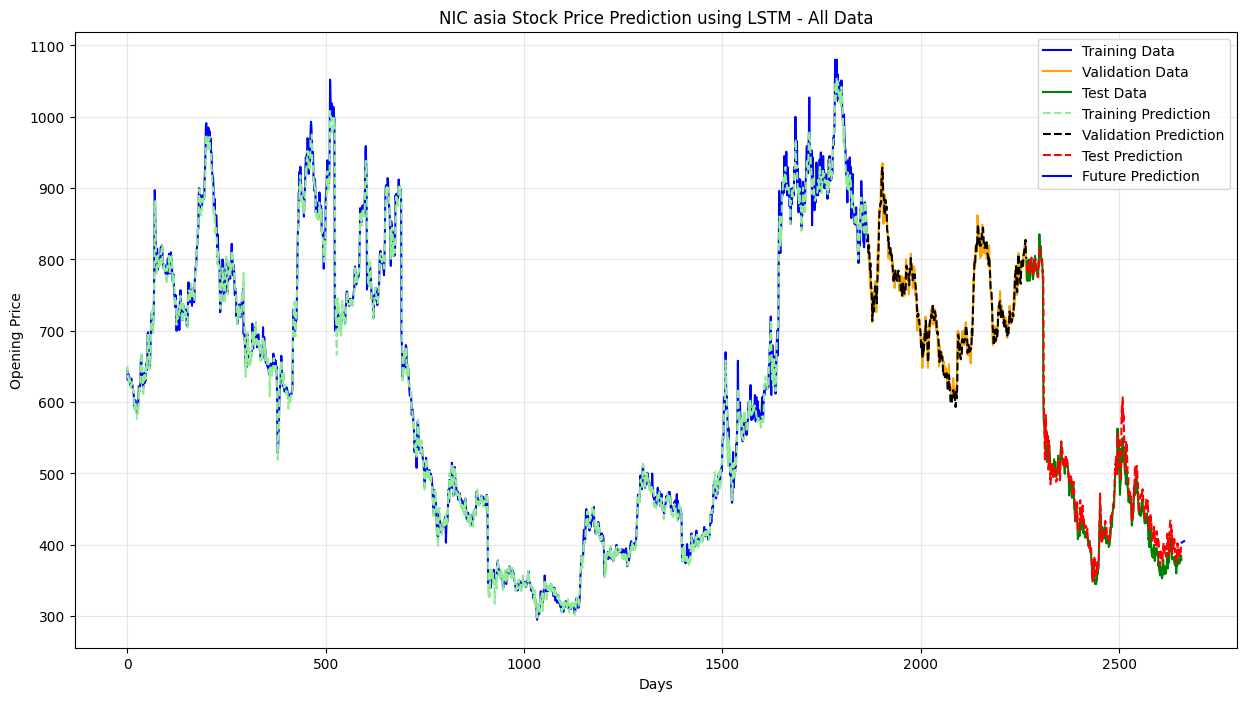

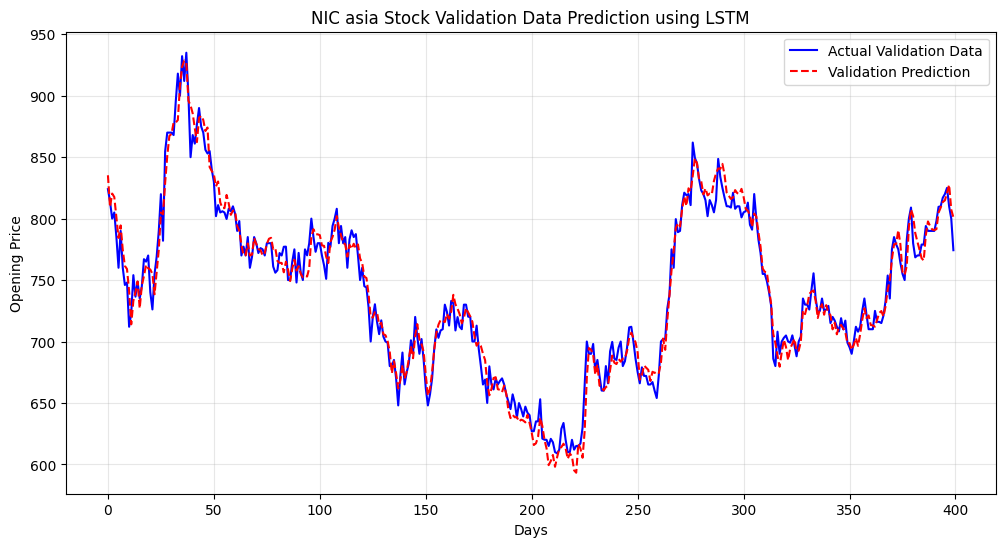

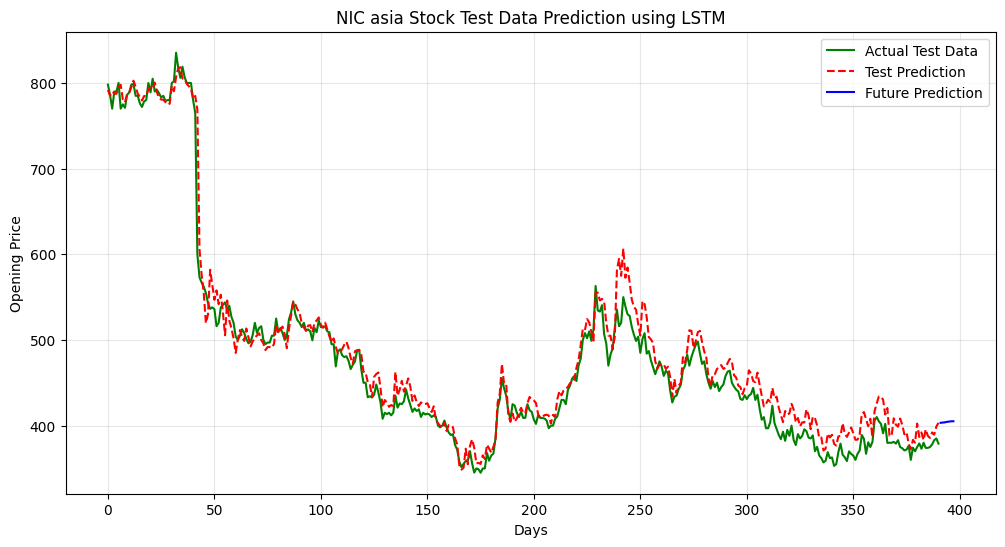


Training BiLSTM model...


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 10, 128)   │     35,840 │ input_layer_30[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 10, 128)   │          0 │ bidirectional_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 128)       │     98,816 │ dropout_38[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 128)       │          0 │ bidirectional_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_31      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 142)       │          0 │ dropout_39[0][0], │
│ (Concatenate)       │                   │            │ input_layer_31[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │      9,152 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1)         │         65 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 143,873 (562.00 KB)

 Trainable params: 143,873 (562.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1387 - mae: 0.2400
Epoch 1: val_loss improved from inf to 0.00158, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1356 - mae: 0.2360 - val_loss: 0.0016 - val_mae: 0.0317 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - mae: 0.0385
Epoch 2: val_loss improved from 0.00158 to 0.00090, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - mae: 0.0385 - val_loss: 9.0159e-04 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - mae: 0.0293
Epoch 3: val_loss improved from 0.00090 to 0.00084, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 8.4113e-04 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 4/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - mae: 0.0253
Epoch 4: val_loss improved from 0.00084 to 0.00046, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - mae: 0.0253 - val_loss: 4.5597e-04 - val_mae: 0.0171 - learning_rate: 0.0010
Epoch 5/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.6743e-04 - mae: 0.0219
Epoch 5: val_loss did not improve from 0.00046
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.6960e-04 - mae: 0.0219 - val_loss: 9.8157e-04 - val_mae: 0.0269 - learning_rate: 0.0010
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.0903e-04 - mae: 0.0211
Epoch 6: val_loss did not improve from 0.00046
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.0901e-04 - mae: 0.0211 - val_loss: 7.8360e-04 - val_mae: 0.0236 - learning_rate: 0.0010
Epoch 7/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7395e-04 - mae: 0.0216
Epoch 7: val_loss improved from 0.00046 to 0.00040, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.6885e-04 - mae: 0.0215 - val_loss: 4.0448e-04 - val_mae: 0.0161 - learning_rate: 0.0010
Epoch 8/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5451e-04 - mae: 0.0180
Epoch 8: val_loss improved from 0.00040 to 0.00023, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.6388e-04 - mae: 0.0181 - val_loss: 2.3199e-04 - val_mae: 0.0120 - learning_rate: 0.0010
Epoch 9/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6897e-04 - mae: 0.0181
Epoch 9: val_loss did not improve from 0.00023
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.7456e-04 - mae: 0.0181 - val_loss: 2.3892e-04 - val_mae: 0.0123 - learning_rate: 0.0010
Epoch 10/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2067e-04 - mae: 0.0176
Epoch 10: val_loss did not improve from 0.00023
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1880e-04 - mae: 0.0175 - val_loss: 3.3092e-04 - val_mae: 0.0143 - learning_rate: 0.0010
Epoch 11/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0375e-04 - mae: 0.0179
Epoch 11: val_loss improved from 0.00023 to 0.00020, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9733e-04 - mae: 0.0178 - val_loss: 1.9795e-04 - val_mae: 0.0111 - learning_rate: 0.0010
Epoch 12/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7300e-04 - mae: 0.0159
Epoch 12: val_loss did not improve from 0.00020
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7244e-04 - mae: 0.0159 - val_loss: 1.9833e-04 - val_mae: 0.0112 - learning_rate: 0.0010
Epoch 13/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6327e-04 - mae: 0.0149
Epoch 13: val_loss did not improve from 0.00020

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7437e-04 - mae: 0.0150 - val_loss: 4.6146e-04 - val_mae: 0.0177 - learning_rate: 0.0010
Epoch 14/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7124e-04 - mae: 0.0154
Epoch 14: val_loss did not improve from 0.00020
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6787e-04 - mae: 0.0153 - val_loss: 3.5546e-04 - val_mae: 0.01

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4636e-04 - mae: 0.0143 - val_loss: 1.8275e-04 - val_mae: 0.0108 - learning_rate: 5.0000e-04
Epoch 16/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0706e-04 - mae: 0.0142
Epoch 16: val_loss did not improve from 0.00018
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0593e-04 - mae: 0.0142 - val_loss: 3.2527e-04 - val_mae: 0.0148 - learning_rate: 5.0000e-04
Epoch 17/50
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0789e-04 - mae: 0.0163
Epoch 17: val_loss did not improve from 0.00018
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.8867e-04 - mae: 0.0162 - val_loss: 3.0054e-04 - val_mae: 0.0137 - learning_rate: 5.0000e-04
Epoch 18/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1344e-04 - mae: 0.0135
Epoch 18: val_loss improved from 0.00018 to 0.00018, saving model to best_BiLSTM_model.h5



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.1835e-04 - mae: 0.0135 - val_loss: 1.7775e-04 - val_mae: 0.0107 - learning_rate: 5.0000e-04
Epoch 19/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2265e-04 - mae: 0.0138
Epoch 19: val_loss did not improve from 0.00018
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2175e-04 - mae: 0.0138 - val_loss: 2.6817e-04 - val_mae: 0.0128 - learning_rate: 2.5000e-04
Epoch 20/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5210e-04 - mae: 0.0132
Epoch 20: val_loss did not improve from 0.00018
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5193e-04 - mae: 0.0132 - val_loss: 2.4006e-04 - val_mae: 0.0120 - learning_rate: 2.5000e-04
Epoch 21/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4105e-04 - mae: 0.0147
Epoch 21: val_loss did not improve from 0.00018
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3918e-04 - mae: 0.0146 - val_loss: 1.9376e-04 - v

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2825e-04 - mae: 0.0128 - val_loss: 1.7438e-04 - val_mae: 0.0105 - learning_rate: 1.2500e-04
Epoch 25/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0621e-04 - mae: 0.0126
Epoch 25: val_loss improved from 0.00017 to 0.00017, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0819e-04 - mae: 0.0127 - val_loss: 1.7389e-04 - val_mae: 0.0105 - learning_rate: 1.2500e-04
Epoch 26/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1862e-04 - mae: 0.0128
Epoch 26: val_loss did not improve from 0.00017
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1882e-04 - mae: 0.0128 - val_loss: 2.0934e-04 - val_mae: 0.0112 - learning_rate: 1.2500e-04
Epoch 27/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5867e-04 - mae: 0.0128
Epoch 27: val_loss did not improve from 0.00017
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5111e-04 - mae: 0.0128 - val_loss: 2.0587e-04 - val_mae: 0.0111 - learning_rate: 1.2500e-04
Epoch 28/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3738e-04 - mae: 0.0126
Epoch 28: val_loss did not improve from 0.00017

Epoch 28: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3703e-04 - mae: 0.0127 - val_loss: 1.9821e-04 - 

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.5912e-04 - mae: 0.0124 - val_loss: 1.6927e-04 - val_mae: 0.0104 - learning_rate: 6.2500e-05
Epoch 31/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5210e-04 - mae: 0.0127
Epoch 31: val_loss did not improve from 0.00017
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4532e-04 - mae: 0.0127 - val_loss: 1.9415e-04 - val_mae: 0.0108 - learning_rate: 6.2500e-05
Epoch 32/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9402e-04 - mae: 0.0121
Epoch 32: val_loss improved from 0.00017 to 0.00017, saving model to best_BiLSTM_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9623e-04 - mae: 0.0121 - val_loss: 1.6562e-04 - val_mae: 0.0103 - learning_rate: 6.2500e-05
Epoch 33/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2444e-04 - mae: 0.0128
Epoch 33: val_loss did not improve from 0.00017

Epoch 33: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2462e-04 - mae: 0.0128 - val_loss: 1.9639e-04 - val_mae: 0.0109 - learning_rate: 6.2500e-05
Epoch 34/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5625e-04 - mae: 0.0121
Epoch 34: val_loss did not improve from 0.00017
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6228e-04 - mae: 0.0121 - val_loss: 1.8083e-04 - val_mae: 0.0105 - learning_rate: 3.1250e-05
Epoch 35/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2337e-04 - mae: 0.0118
Epoch 35: val_loss did not improve from 0.00017
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2955e-04 - mae: 0.0118 - val_loss: 1.7832e-04 - v

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
BiLSTM - Training Data - MAE: 8.0759, MAPE: 1.27%
BiLSTM - Validation Data - MAE: 8.0896, MAPE: 1.09%
BiLSTM - Test Data - MAE: 8.3273, MAPE: 1.78%

--------------------------------------------------
Predicting next 7 days using BiLSTM model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Day 1 (2025-04-19): Predicted Price = Rs.390.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 2 (2025-04-20): Predicted Price = Rs.391.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 3 (2025-04-21): Predicted Price = Rs.391.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 4 (2025-04-22): Predicted Price = Rs.392.10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 5 (2025-04-23): Predicted Price = Rs.392.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Day 6 (2025-04-24): Predicted Price = Rs.393.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Day 7 (2025-04-25): Predicted 

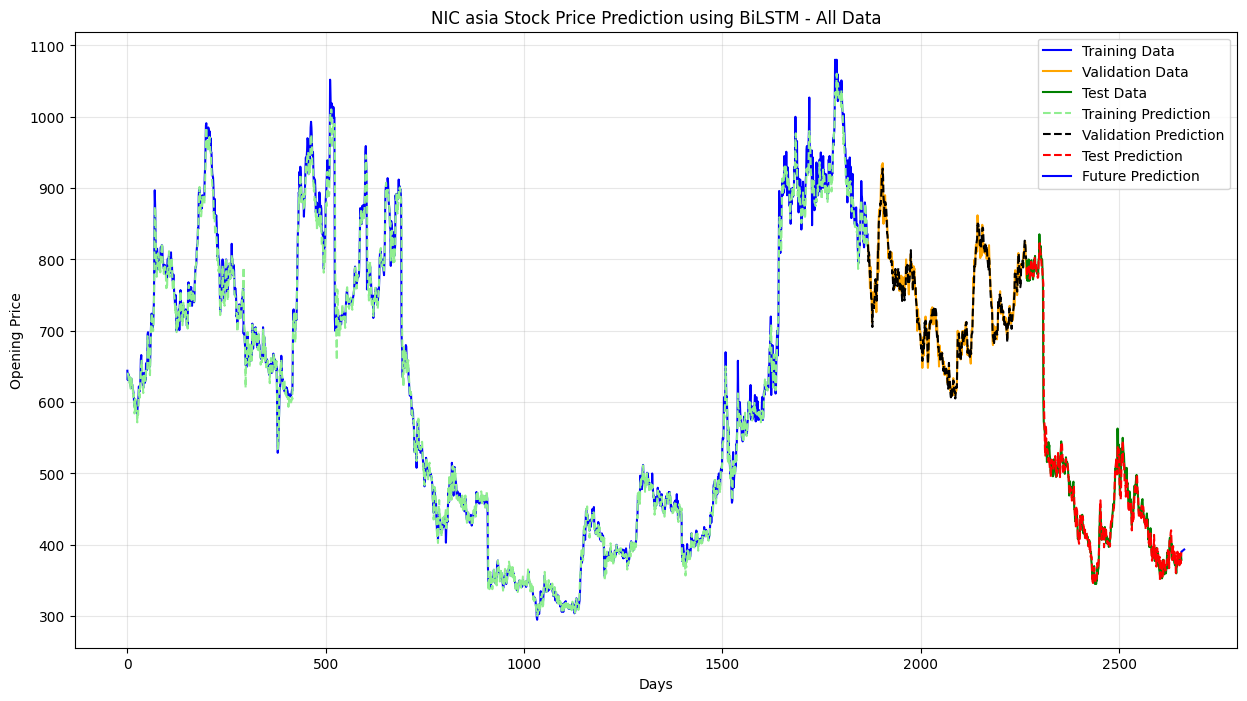

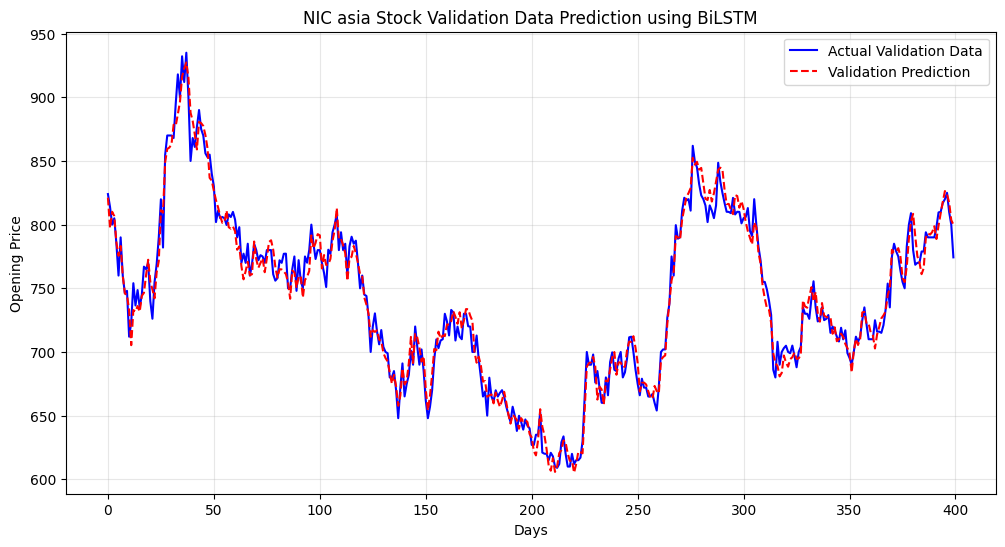

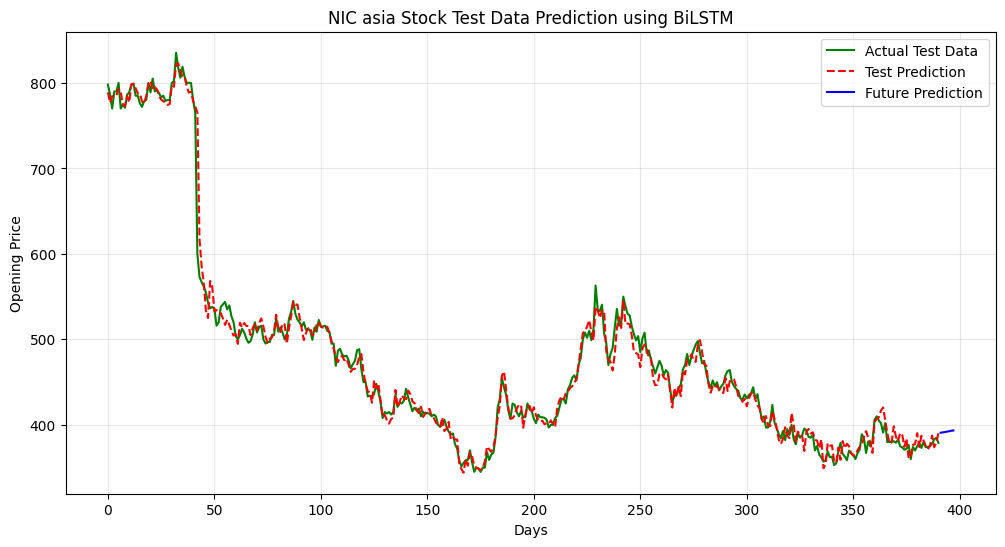


Training GRU model...


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 10, 64)    │     13,632 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 10, 64)    │          0 │ gru_4[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 64)        │     24,960 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 64)        │          0 │ gru_5[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_33      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 78)        │          0 │ dropout_41[0][0], │
│ (Concatenate)       │                   │            │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 64)        │      5,056 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 1)         │         65 │ dense_44[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,713 (170.75 KB)

 Trainable params: 43,713 (170.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1140 - mae: 0.2265
Epoch 1: val_loss improved from inf to 0.00226, saving model to best_GRU_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1049 - mae: 0.2130 - val_loss: 0.0023 - val_mae: 0.0401 - learning_rate: 0.0010
Epoch 2/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mae: 0.0350
Epoch 2: val_loss improved from 0.00226 to 0.00098, saving model to best_GRU_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mae: 0.0349 - val_loss: 9.7510e-04 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 3/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0299
Epoch 3: val_loss improved from 0.00098 to 0.00081, saving model to best_GRU_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mae: 0.0297 - val_loss: 8.1500e-04 - val_mae: 0.0234 - learning_rate: 0.0010
Epoch 4/50
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mae: 0.0236
Epoch 4: val_loss did not improve from 0.00081
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0237 - val_loss: 8.7483e-04 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 5/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6660e-04 - mae: 0.0216
Epoch 5: val_loss improved from 0.00081 to 0.00046, saving model to best_GRU_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6711e-04 - mae: 0.0216 - val_loss: 4.6015e-04 - val_mae: 0.0172 - learning_rate: 0.0010
Epoch 6/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6330e-04 - mae: 0.0205
Epoch 6: val_loss did not improve from 0.00046
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6316e-04 - mae: 0.0205 - val_loss: 9.0768e-04 - val_mae: 0.0262 - learning_rate: 0.0010
Epoch 7/50
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8292e-04 - mae: 0.0190
Epoch 7: val_loss improved from 0.00046 to 0.00044, saving model to best_GRU_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.8380e-04 - mae: 0.0190 - val_loss: 4.4360e-04 - val_mae: 0.0169 - learning_rate: 0.0010
Epoch 8/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9158e-04 - mae: 0.0187
Epoch 8: val_loss improved from 0.00044 to 0.00041, saving model to best_GRU_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.8965e-04 - mae: 0.0186 - val_loss: 4.0670e-04 - val_mae: 0.0162 - learning_rate: 0.0010
Epoch 9/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9548e-04 - mae: 0.0185
Epoch 9: val_loss did not improve from 0.00041
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.8501e-04 - mae: 0.0184 - val_loss: 8.0151e-04 - val_mae: 0.0247 - learning_rate: 0.0010
Epoch 10/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2389e-04 - mae: 0.0165
Epoch 10: val_loss improved from 0.00041 to 0.00031, saving model to best_GRU_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2464e-04 - mae: 0.0166 - val_loss: 3.1457e-04 - val_mae: 0.0140 - learning_rate: 0.0010
Epoch 11/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7045e-04 - mae: 0.0161
Epoch 11: val_loss did not improve from 0.00031
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7225e-04 - mae: 0.0162 - val_loss: 5.6441e-04 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 12/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4716e-04 - mae: 0.0155
Epoch 12: val_loss did not improve from 0.00031
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4763e-04 - mae: 0.0155 - val_loss: 7.7763e-04 - val_mae: 0.0246 - learning_rate: 0.0010
Epoch 13/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3789e-04 - mae: 0.0160
Epoch 13: val_loss did not improve from 0.00031
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3755e-04 - mae: 0.0160 - val_loss: 5.9742e-04 - val_mae: 0.0210 - learning_rate: 0.0010
Epoch 14/50
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - los

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
GRU - Training Data - MAE: 9.9748, MAPE: 1.58%
GRU - Validation Data - MAE: 11.0101, MAPE: 1.51%
GRU - Test Data - MAE: 29.3922, MAPE: 6.74%

--------------------------------------------------
Predicting next 7 days using GRU model...
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Day 1 (2025-04-19): Predicted Price = Rs.345.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 2 (2025-04-20): Predicted Price = Rs.346.23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Day 3 (2025-04-21): Predicted Price = Rs.347.05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Day 4 (2025-04-22): Predicted Price = Rs.347.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Day 5 (2025-04-23): Predicted Price = Rs.347.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 6 (2025-04-24): Predicted Price = Rs.347.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Day 7 (2025-04-25): Predicted Price = Rs.

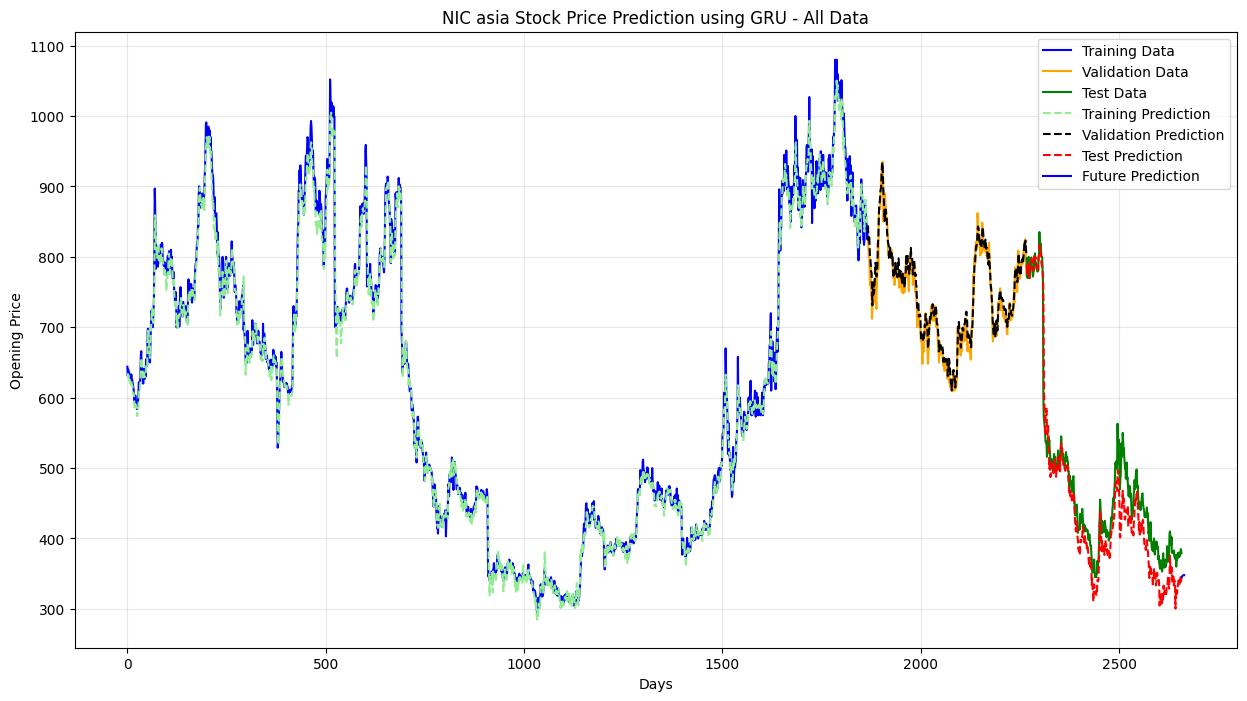

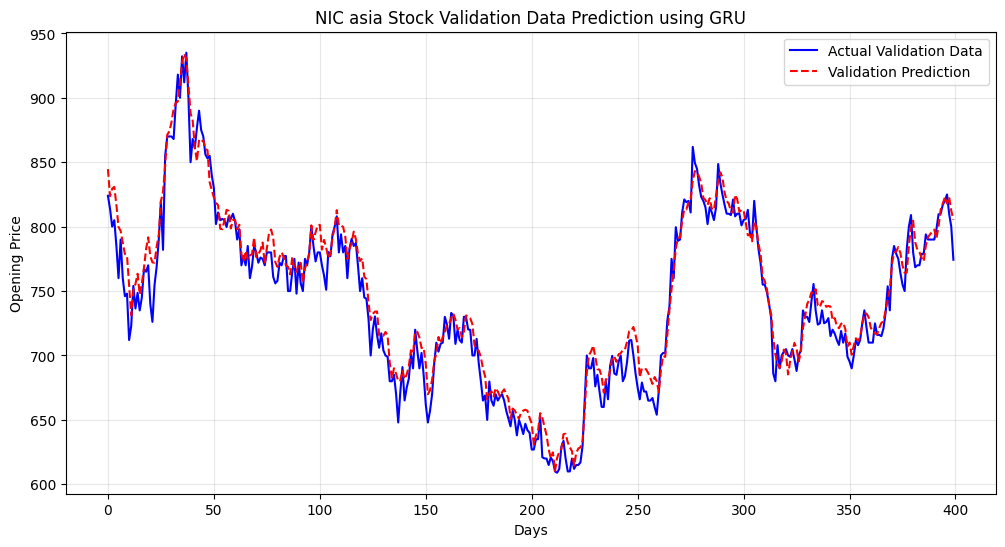

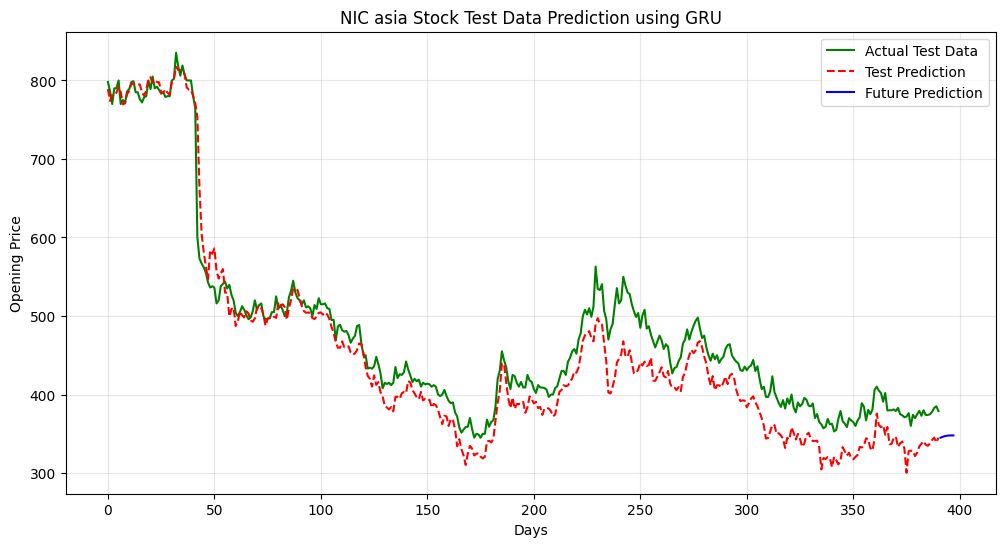


Training Transformer model...


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 10, 128)   │        768 │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 10, 128)   │          0 │ dense_46[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_21       │ (None, 10, 128)   │    330,240 │ positional_encod… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_22       │ (None, 10, 128)   │    330,240 │ functional_21[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ functional_22[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_37      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 142)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 64)        │      9,152 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 1)         │         65 │ dense_51[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 670,465 (2.56 MB)

 Trainable params: 670,465 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.1930 - mae: 0.6028
Epoch 1: val_loss improved from inf to 0.00221, saving model to best_Transformer_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - loss: 1.1796 - mae: 0.5981 - val_loss: 0.0022 - val_mae: 0.0377 - learning_rate: 0.0010
Epoch 2/50
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125 - mae: 0.0875
Epoch 2: val_loss improved from 0.00221 to 0.00169, saving model to best_Transformer_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0123 - mae: 0.0867 - val_loss: 0.0017 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 3/50
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - mae: 0.0632
Epoch 3: val_loss did not improve from 0.00169
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - mae: 0.0628 - val_loss: 0.0074 - val_mae: 0.0813 - learning_rate: 0.0010
Epoch 4/50
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - mae: 0.0624
Epoch 4: val_loss did not improve from 0.00169
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0622 - val_loss: 0.0086 - val_mae: 0.0893 - learning_rate: 0.0010
Epoch 5/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - mae: 0.0489
Epoch 5: val_loss improved from 0.00169 to 0.00100, saving model to best_Transformer_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - mae: 0.0489 - val_loss: 0.0010 - val_mae: 0.0264 - learning_rate: 0.0010
Epoch 6/50
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - mae: 0.0560
Epoch 6: val_loss improved from 0.00100 to 0.00072, saving model to best_Transformer_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - mae: 0.0556 - val_loss: 7.2321e-04 - val_mae: 0.0222 - learning_rate: 0.0010
Epoch 7/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - mae: 0.0541
Epoch 7: val_loss did not improve from 0.00072
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mae: 0.0539 - val_loss: 9.1840e-04 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 8/50
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - mae: 0.0433
Epoch 8: val_loss did not improve from 0.00072
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - mae: 0.0435 - val_loss: 0.0041 - val_mae: 0.0592 - learning_rate: 0.0010
Epoch 9/50
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0358
Epoch 9: val_loss improved from 0.00072 to 0.00048, saving model to best_Transformer_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - mae: 0.0358 - val_loss: 4.7981e-04 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 10/50
50/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae: 0.0339
Epoch 10: val_loss did not improve from 0.00048
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0339 - val_loss: 0.0026 - val_mae: 0.0457 - learning_rate: 0.0010
Epoch 11/50
50/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0329
Epoch 11: val_loss did not improve from 0.00048
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mae: 0.0330 - val_loss: 0.0030 - val_mae: 0.0506 - learning_rate: 0.0010
Epoch 12/50
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0337
Epoch 12: val_loss did not improve from 0.00048
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mae: 0.0336 - val_loss: 0.0049 - val_mae: 0.0669 - learning_rate: 0.0010
Epoch 13/50
50/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0280
Epoch 13: val_l

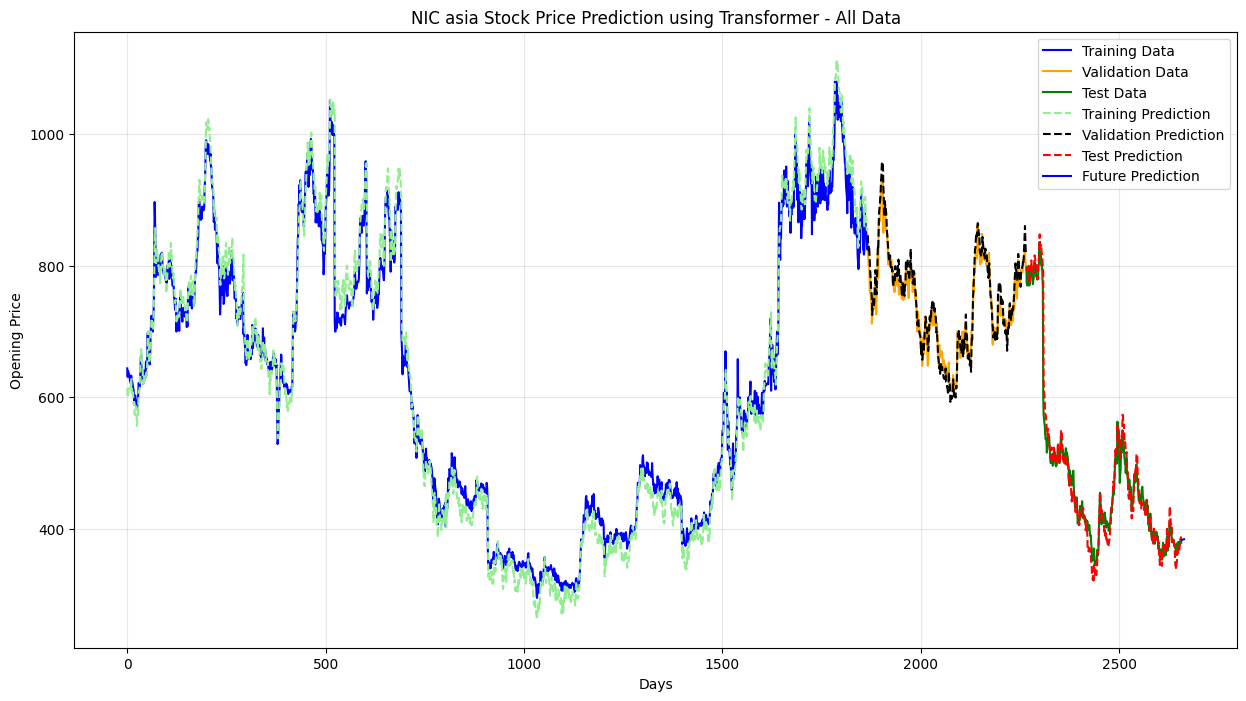

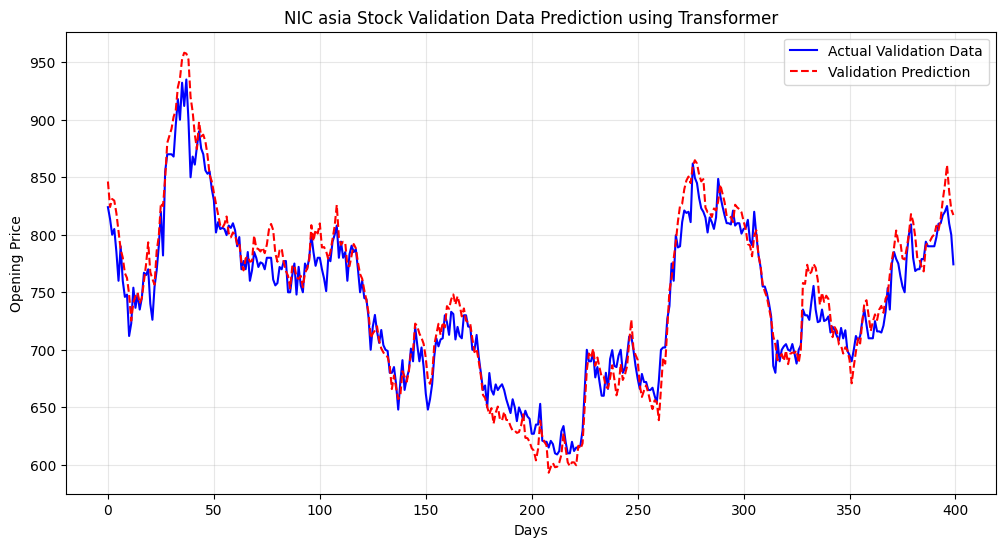

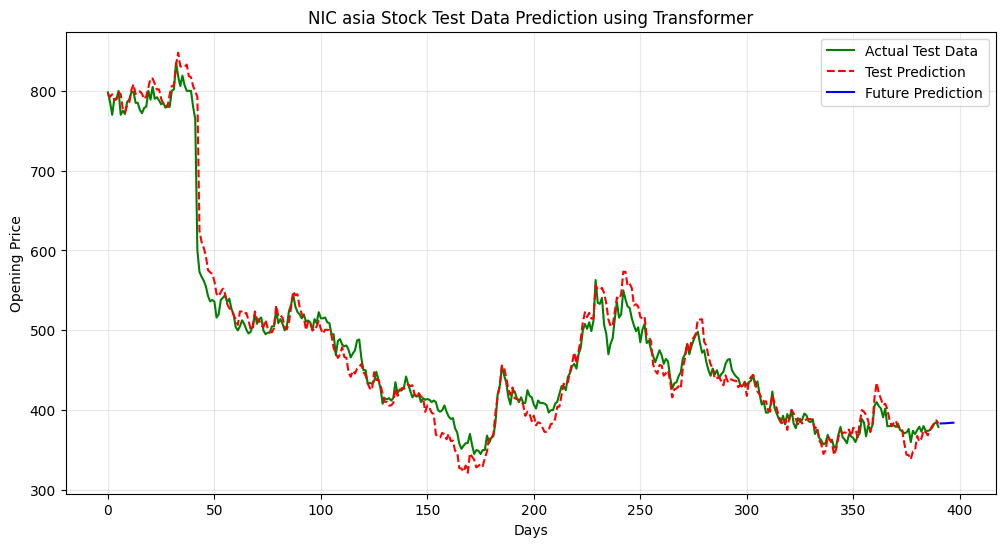


Model Performance Comparison:
         Model  Train MAE  Train MAPE (%)    Val MAE  Val MAPE (%)   Test MAE  \
0         LSTM   7.736158        1.251174   8.976090      1.213539  14.814930   
1       BiLSTM   8.075903        1.268621   8.089634      1.085679   8.327331   
2          GRU   9.974759        1.582582  11.010114      1.507193  29.392226   
3  Transformer  20.665247        3.585429  13.656359      1.842407  12.971519   

   Test MAPE (%)  
0       3.324514  
1       1.782032  
2       6.739913  
3       2.782240  


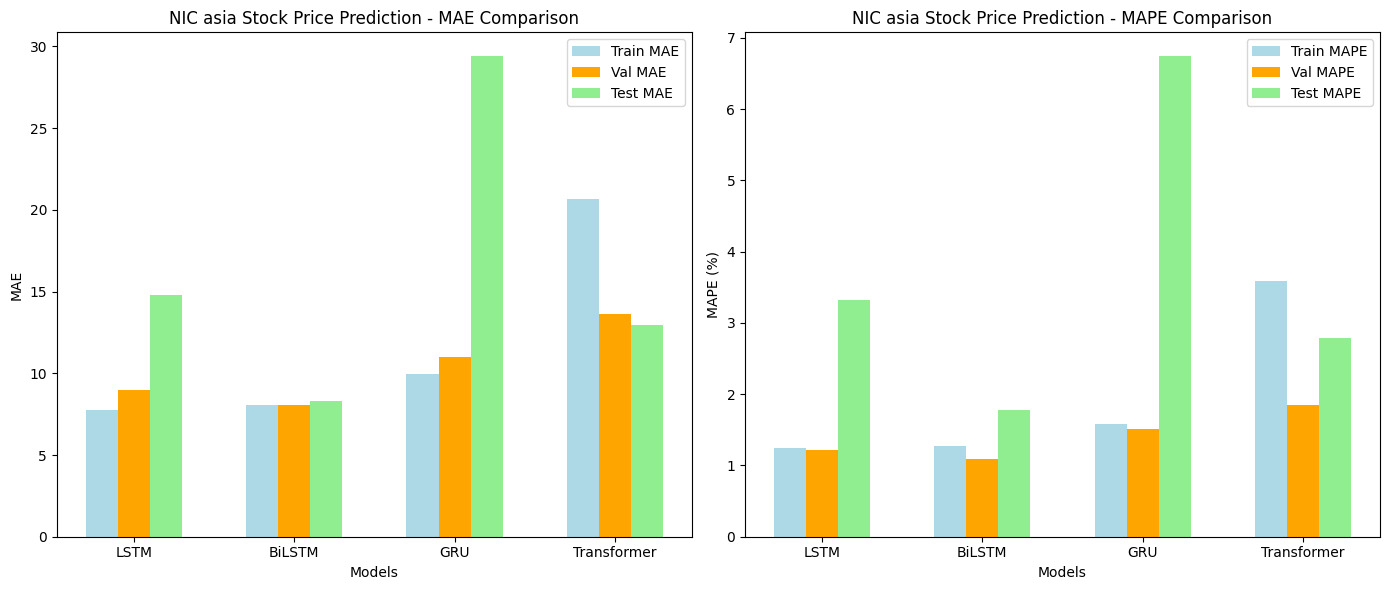

In [22]:
# Run models
model_results, metrics_df = run_models(
    X_seq_train, X_ind_train, y_train,
    X_seq_val, X_ind_val, y_val,
    X_seq_test, X_ind_test, y_test,
    SEQ_LEN, seq_features, num_indicators,
    scaler_y=scaler,
    epochs=50,
    batch_size=32,
    stock_name="NIC asia Stock"
)